In [1]:
!pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.4 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=fdf70c39e33833ede267cf6c7c554d336c565a166e1cbc2193f3974a33aec58e
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import clip
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

In [4]:
json_path = '/content/drive/MyDrive/fashion/train_data.json'
image_path = '/content/drive/MyDrive/fashion/images/test'

In [5]:
input_data = []
with open(json_path, 'r') as f:
	for line in f:
		obj = json.loads(line)
		input_data.append(obj)

In [6]:
input_data[0]

{'image_url': 'https://m.media-amazon.com/images/I/71NZQ-aaASL._AC_UL320_.jpg',
 'image_path': 'images/test/0.jpeg',
 'brand': 'TANTUJA BENGAL HANDLOOM',
 'product_title': "(A Govt. of West Bengal Enterprises) Handloom Cotton Ethnic Wear For Women's-011H8B9699/BB 12 Black",
 'class_label': 'saree'}

In [7]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [9]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 147MiB/s]


In [10]:
class image_dataset():
    def __init__(self, list_image_path,list_txt):
        self.image_path = list_image_path
        self.title  = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title

In [11]:
list_image_path = []
list_txt = []
for item in input_data:
  img_path = image_path + '/' + item['image_path'].split('/')[-1]
  caption = item['class_label']
  list_image_path.append(img_path)
  list_txt.append(caption)

/content/drive/MyDrive/fashion/images/test/0.jpeg
saree


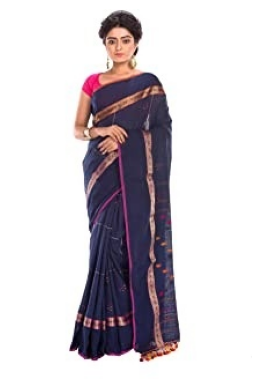

In [12]:
print(list_image_path[0])
print(list_txt[0])

img = Image.open(list_image_path[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
dataset = image_dataset(list_image_path, list_txt)
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [14]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()


if device == "cpu":
  model.float()

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)

In [16]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [17]:
train_losses = []
model.train()

num_epochs = 5
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    epoch_loss = 0
    for batch in pbar:
        optimizer.zero_grad()

        images, texts = batch

        images = images.to(device)
        texts = texts.to(device)

        logits_per_image, logits_per_text = model(images, texts)

        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2

        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")
        epoch_loss += total_loss.item()

    train_losses.append(epoch_loss / len(train_dataloader))

Epoch 4/5, Loss: 2.7578: 100%|██████████| 59/59 [00:52<00:00,  1.12it/s]


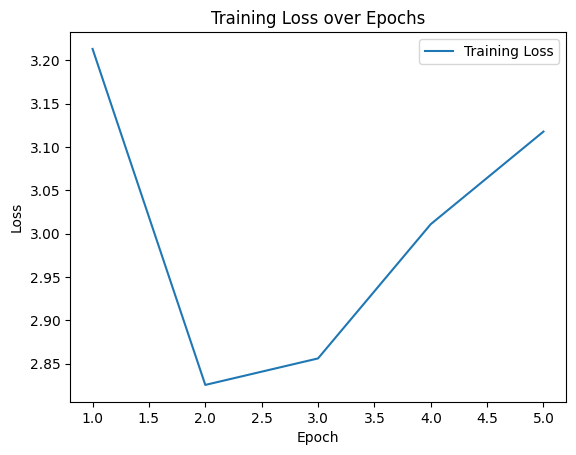

In [18]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [19]:
model_save_path = "/content/drive/MyDrive/clip_model.pth"
torch.save(model.state_dict(), model_save_path)